In [ ]:
import pandas as pd
import numpy as np

# convert numeric code for gender into human readable format
def label_sex(row):
    if row['R_SEX'] == 1:
        return 'Male'
    elif row['R_SEX'] == 2:
        return 'Female'
    else:
        return 'Unknown'

# convert numeric code yes/no answer into human readable form    
def label_yes_no_ans(row, colName):
    if row[colName] == 1:
        return 'Yes'
    elif row[colName] == 2:
        return 'No'
    else:
        return 'Unknown'

# convert numeric code for race into human readable format    
def label_race(row):
    if row['R_HISP'] == 1:
        return 'Hispanic/Latino'
    else:
        if row['R_RACE'] == 1:
            return 'White'
        elif row['R_RACE'] == 2:
            return 'Black'
        elif row['R_RACE'] == 3:
            return 'Asian'
        elif row['R_RACE'] == 4:
            return 'Native'
        elif row['R_RACE'] == 5:
            return 'Islander'
        else:
            return 'Other'
        
# we only read the interesting columns from the NHTS housing file        
household_cols = ["HOUSEID", "DRVRCNT", "HHSIZE", 
                  "HHFAMINC", "HHSTATE", "HHVEHCNT"]
household_data = pd.read_csv('hhpub.csv', usecols=household_cols)
        
# similarly, only read interesting columns from the person file    
person_cols = ["HOUSEID","PERSONID","R_AGE",
               "EDUC", "R_HISP", "R_SEX",
               "R_RACE","WORKER", "DRIVER"]
person_data = pd.read_csv('perpub.csv', usecols=person_cols)

# merge person and house hold data so that we can include household information
# when analysing a person
human_readable_pd = pd.merge(household_data, person_data, 
                             how="inner", on=['HOUSEID'], 
                             left_index=False, 
                             right_index=False, 
                             sort=True, suffixes=("_x", "_y"), 
                             copy=True, indicator=False, 
                             validate='one_to_many')

# convert numeric values of some person fields into human readable format
human_readable_pd['sex'] = person_data.apply(lambda row: label_sex(row), axis=1)
human_readable_pd['driver'] = person_data.apply(lambda row: label_yes_no_ans(row, "DRIVER"), axis=1)
human_readable_pd['worker'] = person_data.apply(lambda row: label_yes_no_ans(row, "WORKER"), axis=1)
human_readable_pd['race'] = person_data.apply(lambda row: label_race(row), axis=1)
human_readable_pd = human_readable_pd.drop(['R_SEX', 'DRIVER', 'WORKER', 'R_HISP', 'R_RACE'], axis=1)
human_readable_pd.head()

,HOUSEID,HHSIZE,HHVEHCNT,HHFAMINC,DRVRCNT,HHSTATE,PERSONID,R_AGE,EDUC,sex,driver,worker,race
0,30000007,3,5,7,3,NC,1,67,3,Female,Yes,No,Black
1,30000007,3,5,7,3,NC,2,66,3,Male,Yes,Yes,Black
2,30000007,3,5,7,3,NC,3,28,2,Female,Yes,No,Black
3,30000008,2,4,8,2,WI,1,55,5,Male,Yes,Yes,White
4,30000008,2,4,8,2,WI,2,49,4,Female,Yes,Yes,White


In [ ]:
# function to convert numeric codes for travel source/destination into useful human readable
# categories
def interpret_trip(row):
    if row["WHYTRP1S"] == 1:
        return "At_Home"
    elif row["WHYTRP1S"] == 10:
        if row["WHYTO"] == 2:
            return "At_Home"
        else:
            return "At_Work"
    elif row["WHYTRP1S"] == 20:
        if row["WHYTO"] == 8:
            return "At_School"
        elif row["WHYTO"] == 19:
            return "At_Religious"
        elif row["WHYTO"] == 9:
            return "At_Child_Care"
        elif row["WHYTO"] == 10:
            return "At_Adult_Care"
        else:
            return "Unknown"
    elif row["WHYTRP1S"] == 30:
        return "At_Medical"
    elif row["WHYTRP1S"] == 40:
        return "At_Errand"
    elif row["WHYTRP1S"] == 50:
        if row["WHYTO"] == 15 or row["WHYTO"] == 16:
            return "At_Recreation"
        else:
            return "At_Social"
    elif row["WHYTRP1S"] == 80:
        return "At_Restaurant"
    else:
        return "At_Other"

# function to update negative stay time entries so negative so that their sum remains also negative
def intensify_negative_stay_time(row):
    if (row["stay_untuned"] < 0.0):
        return -25
    else:
        return row["stay_untuned"]
        

# read only interesting columns from the trip data file        
trip_cols = ["HOUSEID","PERSONID","TDTRPNUM", 
             "DWELTIME", "DBHUR",  "WHYFROM", 
             "WHYTO", "WHYTRP1S"]
trip_data = pd.read_csv('trippub.csv', usecols=trip_cols, error_bad_lines=False)
human_readable_td = trip_data

# convert the location information in each trip record to the human readable categories we are
# interested to analyse
human_readable_td['location'] = trip_data.apply(lambda row: interpret_trip(row), axis=1)
# convert the dwelling time in the trip record to hours from minutes format
human_readable_td['stay_untuned'] = trip_data['DWELTIME'] / 60 
human_readable_td = human_readable_td.drop(["DWELTIME", "DBHUR", 
                                            "WHYFROM", "WHYTO", 
                                            "WHYTRP1S"], axis=1)

# do a peculier update of stay entries having negative value by make them all -25 hours; this is
# done so that such entries force the sum of stay time in the related location negative when we
# sum up the entries later to compute the total stay time.
human_readable_td['stay'] = trip_data.apply(
    lambda row: intensify_negative_stay_time(row), axis=1)
human_readable_td = human_readable_td.drop(["stay_untuned"], axis=1)    

human_readable_td.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,HOUSEID,PERSONID,TDTRPNUM,location,stay
0,30000007,1,1,At_Religious,4.916667
1,30000007,1,2,At_Home,-25.000000
2,30000007,2,1,At_Home,9.000000
3,30000007,2,2,At_Work,-25.000000
4,30000007,3,1,At_School,5.500000


In [ ]:
# combine the person records with trip records
combined_data = pd.merge(human_readable_pd, 
                         human_readable_td, how="inner", 
                         on=['HOUSEID', 'PERSONID'], 
                         left_index=False, right_index=False, 
                         sort=True, 
                         suffixes=("_x", "_y"), copy=True, 
                         indicator=False, 
                         validate='one_to_many')

# currently we are doing analysis of people of missouri only; so removing all entries
# people living in other states
combined_data = combined_data.loc[combined_data["HHSTATE"] == 'MO']
combined_data = combined_data.drop(["HHSTATE"], axis=1)
combined_data.head()

,HOUSEID,HHSIZE,HHVEHCNT,HHFAMINC,DRVRCNT,PERSONID,R_AGE,EDUC,sex,driver,worker,race,TDTRPNUM,location,stay
9019,30010221,2,2,7,2,1,60,5,Male,Yes,Yes,Other,1,At_Work,2.000000
9020,30010221,2,2,7,2,1,60,5,Male,Yes,Yes,Other,2,At_Work,0.166667
9021,30010221,2,2,7,2,1,60,5,Male,Yes,Yes,Other,3,At_Work,0.083333
9022,30010221,2,2,7,2,1,60,5,Male,Yes,Yes,Other,4,At_Work,1.000000
9023,30010221,2,2,7,2,1,60,5,Male,Yes,Yes,Other,5,At_Restaurant,0.833333


In [ ]:
# create separate columns for stay time in different types of places while retaining the
# person identifier only (house-id, person-id tuple) as the pivot columns
agg_stay_report = combined_data.pivot_table(values="stay", 
                          index=["HOUSEID", "PERSONID"], 
                          columns="location", aggfunc=pd.Series.sum)
agg_stay_report = agg_stay_report.fillna(0)
agg_stay_report = agg_stay_report.reset_index()
agg_stay_report.head()

location,HOUSEID,PERSONID,At_Child_Care,At_Errand,At_Home,At_Medical,At_Other,At_Recreation,At_Religious,At_Restaurant,At_School,At_Social,At_Work
0,30010221,1,0.0,0.166667,-21.333333,0.0,0.0,0.000000,0.0,0.833333,0.0,0.0,6.166667
1,30010430,1,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,-25.000000
2,30010984,1,0.0,0.000000,-22.666667,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,7.333333
3,30010984,2,0.0,0.666667,-18.416667,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,30010984,3,0.0,0.666667,-18.416667,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000


In [ ]:
# merge person data with stay location data using the person identifier
stay_summary = pd.merge(human_readable_pd, agg_stay_report, how="inner", on=['HOUSEID', 'PERSONID'],
    left_index=False, right_index=False, sort=True, suffixes=("_x", "_y"), copy=True,
    indicator=False, validate='one_to_one')

# identifier columns are no longer needed; so dropping them
stay_summary = stay_summary.drop(["driver", "HOUSEID", "PERSONID"], axis=1)

# remove any row where the education level or worker state does not have useful values
stay_summary = stay_summary[stay_summary['EDUC'] > -1]
stay_summary = stay_summary[stay_summary['worker'] != 'Unknown']
stay_summary.head(20)

,HHSIZE,HHVEHCNT,HHFAMINC,DRVRCNT,HHSTATE,R_AGE,EDUC,sex,worker,race,...,At_Errand,At_Home,At_Medical,At_Other,At_Recreation,At_Religious,At_Restaurant,At_School,At_Social,At_Work
0,2,2,7,2,MO,60,5,Male,Yes,Other,...,0.166667,-21.333333,0.000000,0.000000,0.000000,0.00,0.833333,0.000000,0.000000,6.166667
1,2,0,5,0,MO,33,3,Female,Yes,Black,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,-25.000000
2,3,1,5,2,MO,33,5,Female,Yes,White,...,0.000000,-22.666667,0.000000,0.000000,0.166667,0.00,0.000000,0.000000,0.000000,7.333333
3,3,1,5,2,MO,35,5,Male,No,White,...,0.666667,-18.416667,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
5,1,2,4,1,MO,45,4,Female,Yes,White,...,0.750000,-25.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
6,1,1,4,1,MO,71,3,Female,No,White,...,0.333333,-25.000000,0.000000,0.000000,0.000000,3.75,0.000000,0.000000,0.000000,0.000000
7,3,2,6,2,MO,59,4,Female,Yes,White,...,0.000000,0.000000,0.000000,0.500000,1.333333,0.00,0.000000,0.000000,-18.750000,0.000000
8,3,2,6,2,MO,60,3,Male,No,White,...,0.166667,-25.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
9,2,3,9,2,MO,60,3,Female,No,White,...,1.666667,-24.333333,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
10,3,3,11,3,MO,54,5,Male,Yes,White,...,0.000000,-25.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,11.050000


In [ ]:
# if a person cannot specify how long he/she stayed in a particular place during a trip then we are 
# assuming that whatever time remaining from 24 hours after subtracting all other trip stay locations
# should be assigned to that particular trip destination
def adjustUncertainStayTime(row, stay_columns):
    specific_stay_sum = 0.0
    uncertain_col_exist = False
    uncertain_col_name = ""
    for col in stay_columns:
        if row[col] < 0.0:
            uncertain_col_exist = True
            uncertain_col_name = col
        else:
            specific_stay_sum += row[col]
    if uncertain_col_exist:
        row[uncertain_col_name] = 24 - specific_stay_sum
    return row    

# filter the location of stay related columns
all_columns = stay_summary.columns
stay_type_columns = all_columns.drop(["HHSIZE","HHVEHCNT","HHFAMINC",
                                      "DRVRCNT","HHSTATE", 
                                      'R_AGE', 'EDUC', 
                                      'sex', 'worker', 'race'])

# perform the the dwelling time adjustment for rows with uncertain entries
stay_column_list = stay_type_columns.to_list() 
stay_summary = stay_summary.apply(lambda row: adjustUncertainStayTime(row, stay_column_list), axis=1)

# drop the state column from data as it is no longer needed
stay_summary = stay_summary.drop(["HHSTATE"], axis=1)
stay_summary[stay_column_list].head(20)

,At_Child_Care,At_Errand,At_Home,At_Medical,At_Other,At_Recreation,At_Religious,At_Restaurant,At_School,At_Social,At_Work
0,0.0,0.166667,16.833333,0.000000,0.000000,0.000000,0.000000,0.833333,0.000000,0.000000,6.166667
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000
2,0.0,0.000000,16.500000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,7.333333
3,0.0,0.666667,23.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.0,0.750000,23.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.0,0.333333,19.916667,0.000000,0.000000,0.000000,3.750000,0.000000,0.000000,0.000000,0.000000
7,0.0,0.000000,0.000000,0.000000,0.500000,1.333333,0.000000,0.000000,0.000000,22.166667,0.000000
8,0.0,0.166667,23.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.0,1.666667,22.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,0.0,0.000000,12.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.050000


In [ ]:
# function to convert a column representing a category variable into multiple columns with
# boolean score indicating whether a person belongs to a particular category. For example,
# race is converted into multiple columns such as is_white, is_black, is_hispanic.
def process_category_column(df, col_name):
    if col_name not in df.columns:
        return df
    unique_values = df[col_name].unique()
    for value in unique_values:
        df[f'c_{col_name}_{value}'] = df[col_name].apply(lambda x: 1 if x == value else 0)
    del df[col_name]
    return df

#  function to convert all category columns in the original dataset
def process_all_category_columns(df, col_list):
    for col in col_list:
        df = process_category_column(df, col)
    return df    

# modify the category columns' data so that we can do one regression to fit and estimate each
# person to a particular location of stay type
stay_summary = process_all_category_columns(stay_summary, ['sex', 'race', 'worker'])

# rename some of the columns of both the stay summary and the person data to more human 
# readable format
rename_mappings = {'R_AGE': 'age', 'EDUC': 'education', 
                   'HHSIZE': 'house_size', 'HHFAMINC': 'house_income', 
                   'HHVEHCNT': 'house_vehicle','DRVRCNT': 'driver_count'}
stay_summary = stay_summary.rename(columns=rename_mappings)
human_readable_pd = human_readable_pd.rename(columns=rename_mappings) 
stay_summary.head()


,house_size,house_vehicle,house_income,driver_count,age,education,At_Child_Care,At_Errand,At_Home,At_Medical,...,At_Work,c_sex_Male,c_sex_Female,c_race_Other,c_race_Black,c_race_White,c_race_Hispanic/Latino,c_race_Asian,c_worker_Yes,c_worker_No
0,2,2,7,2,60,5,0.0,0.166667,16.833333,0.0,...,6.166667,1,0,1,0,0,0,0,1,0
1,2,0,5,0,33,3,0.0,0.000000,0.000000,0.0,...,24.000000,0,1,0,1,0,0,0,1,0
2,3,1,5,2,33,5,0.0,0.000000,16.500000,0.0,...,7.333333,0,1,0,0,1,0,0,1,0
3,3,1,5,2,35,5,0.0,0.666667,23.333333,0.0,...,0.000000,1,0,0,0,1,0,0,0,1
5,1,2,4,1,45,4,0.0,0.750000,23.250000,0.0,...,0.000000,0,1,0,0,1,0,0,1,0


In [ ]:
from numpy import arange

# import the lasso package to do linear regression with L1 penalty
from sklearn.linear_model import Lasso

# import these two additional packages to predict the model parameters for regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

# function to determine the best Lasso model by repeated search; this is taken from following
# url: https://machinelearningmastery.com/lasso-regression-with-python/
def findBestModel(X, y):
    # define model
    model = Lasso()
    # define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define grid
    grid = dict()
    grid['alpha'] = arange(0, 1, 0.01)
    # define search
    search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # perform the search
    results = search.fit(X, y)
    alp = results.best_params_["alpha"]
    # do final regression with the best fitted value
    model = Lasso(alpha=alp)
    model.fit(X, y)
    return model

# select the columns representing person attributes
independent_columns = stay_summary.filter(regex='^c_',axis=1).columns.to_list()
independent_columns.extend(["age", "education", "house_size", 
                            "house_income", "house_vehicle", "driver_count"])
independent_columns.sort()

print(independent_columns)


# run regression to fit the stay time at home
X, y = stay_summary[independent_columns], stay_summary['At_Home']
home_model = findBestModel(X, y)
print("\nResult of running Lasso regression for stay at home time prediction.")
print(f"Intercept: {home_model.intercept_}")
print(f"Coefficients: {home_model.coef_}")
print(f"Fitting score: {home_model.score(X, y)}")

# run regression to fit the stay time at work
workers = stay_summary[stay_summary['c_worker_Yes'] == 1] 
X, y = workers[independent_columns], workers['At_Work']
work_model = findBestModel(X, y)
print("\nResult of running Lasso regression for stay at work time prediction.")
print(f"Intercept: {work_model.intercept_}")
print(f"Coefficients: {work_model.coef_}")
print(f"Fitting score: {work_model.score(X, y)}")

# run regression to fit the stay time at religeous events
X, y = stay_summary[independent_columns], stay_summary['At_Religious']
religious_model = findBestModel(X, y)
print("\nResult of running Lasso regression for stay at religeous activities time prediction.")
print(f"Intercept: {religious_model.intercept_}")
print(f"Coefficients: {religious_model.coef_}")
print(f"Fitting score: {religious_model.score(X, y)}")

# run regression to fit the stay time at school
students = stay_summary[stay_summary['At_School'] > 0]
X, y = students[independent_columns], students['At_School']
school_model = findBestModel(X, y)
print("\nResult of running Lasso regression for stay at school time prediction.")
print(f"Intercept: {school_model.intercept_}")
print(f"Coefficients: {school_model.coef_}")
print(f"Fitting score: {school_model.score(X, y)}")

['age', 'c_race_Asian', 'c_race_Black', 'c_race_Hispanic/Latino', 'c_race_Other', 'c_race_White', 'c_sex_Female', 'c_sex_Male', 'c_worker_No', 'c_worker_Yes', 'driver_count', 'education', 'house_income', 'house_size', 'house_vehicle']

Result of running Lasso regression for stay at home time prediction.
Intercept: 15.829028318458981
Coefficients: [ 3.06251835e-02  0.00000000e+00 -2.05701057e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  7.05178551e-01 -1.05784350e-15
  2.89704740e+00 -8.17272052e-15  1.27410585e-01 -6.89918231e-02
 -1.54175107e-01 -1.06156234e-01 -1.79683485e-02]
Fitting score: 0.15286299370528922

Result of running Lasso regression for stay at work time prediction.
Intercept: 7.259307155971557
Coefficients: [-6.37914343e-03 -0.00000000e+00  2.61408844e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -1.27664586e+00  2.50098135e-16
  0.00000000e+00  0.00000000e+00 -3.14633183e-01  4.78550735e-02
 -8.75379103e-02  1.37022764e-03 -4.36933863e-02]
Fitting score

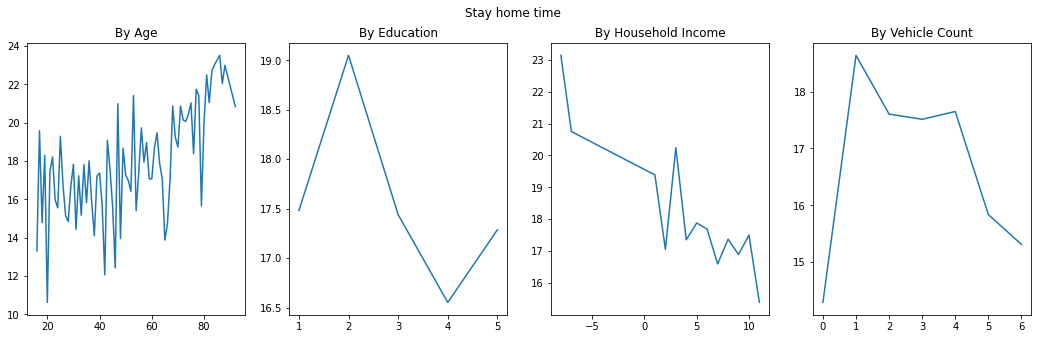

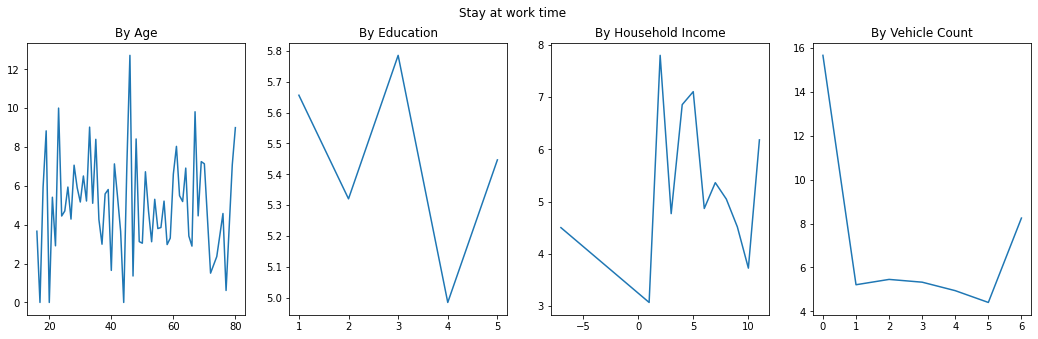

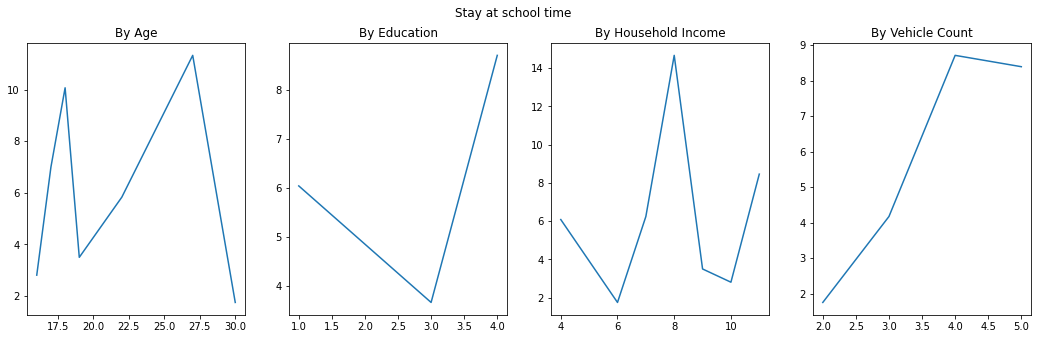

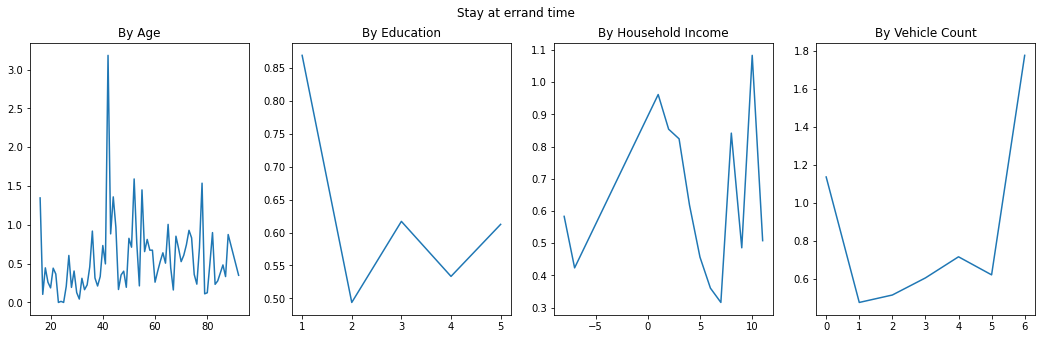

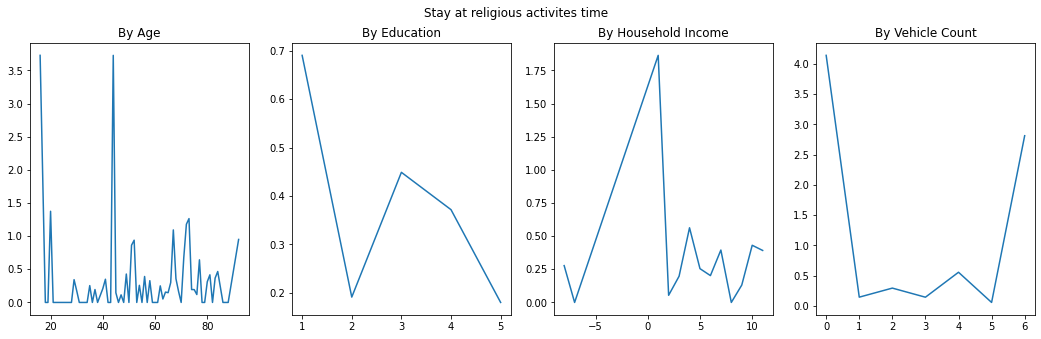

In [ ]:
import matplotlib.pyplot as plt

# visually analyse the relation between stay home time and sensible impact parameters
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(18, 5)
fig.suptitle('Stay home time')
home_stay_by_age_avg = stay_summary.groupby(['age'])['At_Home'].mean()
ax1.plot(home_stay_by_age_avg)
#ax1.scatter(stay_summary['age'], stay_summary['At_Home']) 
ax1.set_title("By Age")
home_stay_by_edu_avg = stay_summary.groupby(['education'])['At_Home'].mean()
ax2.plot(home_stay_by_edu_avg)
#ax2.scatter(stay_summary['education'], stay_summary['At_Home']) 
ax2.set_title("By Education")
home_stay_by_income_avg = stay_summary.groupby(['house_income'])['At_Home'].mean()
ax3.plot(home_stay_by_income_avg)
#ax3.scatter(stay_summary['house_income'], stay_summary['At_Home']) 
ax3.set_title("By Household Income")
home_stay_by_vehicle_avg = stay_summary.groupby(['house_vehicle'])['At_Home'].mean()
ax4.plot(home_stay_by_vehicle_avg)
#ax4.scatter(stay_summary['house_vehicle'], stay_summary['At_Home']) 
ax4.set_title("By Vehicle Count")
plt.show()

# visually analyse the relation between stay at work time and sensible impact parameters
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(18, 5)
fig.suptitle('Stay at work time')
work_stay_by_age_avg = workers.groupby(['age'])['At_Work'].mean()
ax1.plot(work_stay_by_age_avg)
#ax1.scatter(workers['age'], workers['At_Work']) 
ax1.set_title("By Age") 
work_stay_by_edu_avg = workers.groupby(['education'])['At_Work'].mean()
ax2.plot(work_stay_by_edu_avg)
#ax2.scatter(workers['education'], workers['At_Work']) 
ax2.set_title("By Education")
work_stay_by_income_avg = workers.groupby(['house_income'])['At_Work'].mean()
ax3.plot(work_stay_by_income_avg)
#ax3.scatter(workers['house_income'], workers['At_Work']) 
ax3.set_title("By Household Income")
work_stay_by_vehicle_avg = workers.groupby(['house_vehicle'])['At_Work'].mean()
ax4.plot(work_stay_by_vehicle_avg)
#ax4.scatter(workers['house_vehicle'], workers['At_Work']) 
ax4.set_title("By Vehicle Count")
plt.show()

# visually analyse the relation between stay at school time and sensible impact parameters
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(18, 5)
fig.suptitle('Stay at school time') 
school_stay_by_age_avg = students.groupby(['age'])['At_School'].mean()
ax1.plot(school_stay_by_age_avg)
#ax1.scatter(students['age'], students['At_School']) 
ax1.set_title("By Age") 
school_stay_by_edu_avg = students.groupby(['education'])['At_School'].mean()
ax2.plot(school_stay_by_edu_avg)
#ax2.scatter(students['education'], students['At_School']) 
ax2.set_title("By Education")
school_stay_by_income_avg = students.groupby(['house_income'])['At_School'].mean()
ax3.plot(school_stay_by_income_avg)
#ax3.scatter(students['house_income'], students['At_School']) 
ax3.set_title("By Household Income")
school_stay_by_vehicle_avg = students.groupby(['house_vehicle'])['At_School'].mean()
ax4.plot(school_stay_by_vehicle_avg)
#ax4.scatter(students['house_vehicle'], students['At_School']) 
ax4.set_title("By Vehicle Count")
plt.show()

# visually analyse the relation between stay at errand time and sensible impact parameters
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(18, 5)
fig.suptitle('Stay at errand time') 
errand_stay_by_age_avg = stay_summary.groupby(['age'])['At_Errand'].mean()
ax1.plot(errand_stay_by_age_avg)
ax1.set_title("By Age") 
errand_stay_by_edu_avg = stay_summary.groupby(['education'])['At_Errand'].mean()
ax2.plot(errand_stay_by_edu_avg)
ax2.set_title("By Education")
errand_stay_by_income_avg = stay_summary.groupby(['house_income'])['At_Errand'].mean()
ax3.plot(errand_stay_by_income_avg)
ax3.set_title("By Household Income")
errand_stay_by_vehicle_avg = stay_summary.groupby(['house_vehicle'])['At_Errand'].mean()
ax4.plot(errand_stay_by_vehicle_avg)
ax4.set_title("By Vehicle Count")
plt.show()

# visually analyse the relation between stay at relireligiousgious activities time and sensible impact parameters
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(18, 5)
fig.suptitle('Stay at religious activites time') 
religious_stay_by_age_avg = stay_summary.groupby(['age'])['At_Religious'].mean()
ax1.plot(religious_stay_by_age_avg)
ax1.set_title("By Age") 
religious_stay_by_edu_avg = stay_summary.groupby(['education'])['At_Religious'].mean()
ax2.plot(religious_stay_by_edu_avg)
ax2.set_title("By Education")
religious_stay_by_income_avg = stay_summary.groupby(['house_income'])['At_Religious'].mean()
ax3.plot(religious_stay_by_income_avg)
ax3.set_title("By Household Income")
religious_stay_by_vehicle_avg = stay_summary.groupby(['house_vehicle'])['At_Religious'].mean()
ax4.plot(religious_stay_by_vehicle_avg)
ax4.set_title("By Vehicle Count")
plt.show()


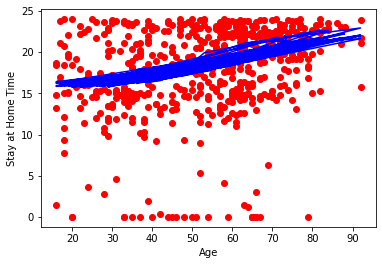

Fitting score: 0.05186459171332303


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

X, y = stay_summary[independent_columns], stay_summary['At_Home']

regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)

plt.scatter(X['age'], y, color = 'red')
plt.plot(X['age'], regressor.predict(X), color = 'blue')
plt.xlabel('Age')
plt.ylabel('Stay at Home Time')
plt.show()
print(f"Fitting score: {regressor.score(X, y)}")

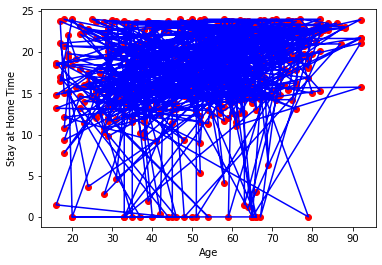

Fitting score: 0.9989525546618748


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

X, y = stay_summary[independent_columns], stay_summary['At_Home']

regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X, y)

y_pred = regressor.predict(X)

plt.scatter(X['age'], y, color = 'red')
plt.plot(X['age'], y_pred, color = 'blue')
plt.xlabel('Age')
plt.ylabel('Stay at Home Time')
plt.show()

print(f"Fitting score: {r2_score(y, y_pred)}")

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


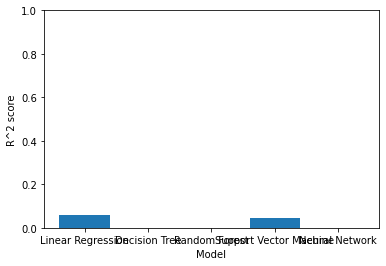

In [ ]:
import matplotlib.pyplot as plt

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the models to try
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Machine': SVR(),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 100))
}

# Fit each model and calculate its R^2 score on the testing set
scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    scores[name] = score

# Plot the scores as a bar chart
fig, ax = plt.subplots()
ax.bar(scores.keys(), scores.values())
ax.set_xlabel('Model')
ax.set_ylabel('R^2 score')
ax.set_ylim([0, 1])
plt.show()

In [ ]:
import matplotlib.pyplot as plt

models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Decision Tree', 'Random Forest']
scores = [lin_reg_score, ridge_score, lasso_score, tree_score, forest_score]

plt.bar(models, scores)
plt.xlabel('Model')
plt.ylabel('Fitness Score')
plt.title('Comparison of Regression Models')
plt.show()

NameError: ignored